/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:257: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


3054.29770294 True 21038


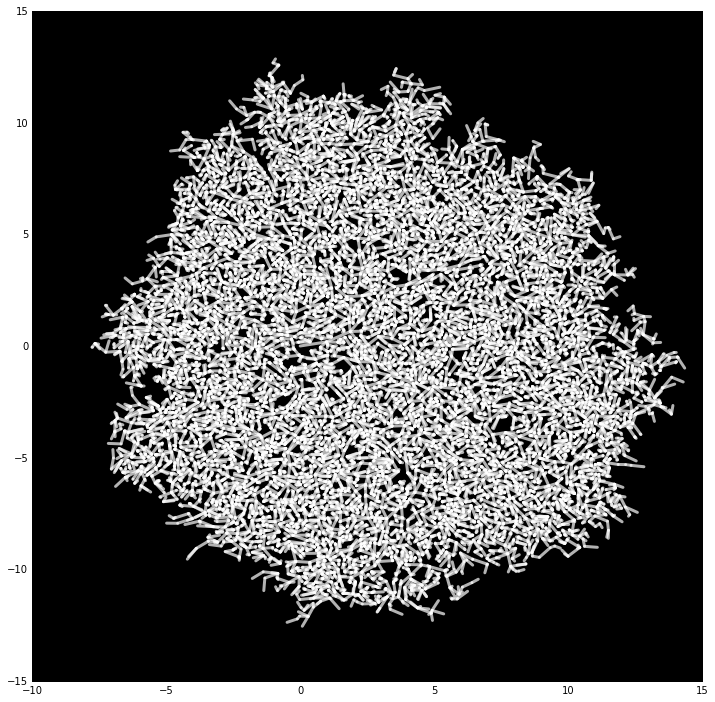

In [35]:
import numpy as np
import shapely.geometry as shg
import matplotlib.pyplot as plt
import copy as cp

%matplotlib inline

COLOR = {
    True:  'white',
    False: '#ffcc33'
    }

def v_color(ob):
    return COLOR[ob.is_simple]

def plot_tree(ax,ob):        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, 'o', color='#000000', zorder=1)
    
    for line in ob:
        x, y = line.xy
        ax.plot(x, y, color=v_color(ob), alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

##########################################################

# no of iterations to run

iterations = 500

# max angle for expander node

max = 20

# max angle for drawed node

max_branch = 137.5

# bfactor - maximal branch length

bfactor = .6

# minimal distance between branches

min_dist = .1

# maximal number of branches at given node

branches = 4

#branching fraction

bfrac = 10

# initialize list to store segments

segments = []

# stack initial point

segments_term = [np.array([0.,0])]

# expander node - for main branch

expander = 1

# max iterations for expander node loop

expander_iters = 15

# max iterations for drawed node loop

drawed_iters = 15

# initial values

node_idx = 1

# dictionaries to store parent-child an vv relations and store previous angle

# child to parent mapping

chp = {}

chp[1] = 0

# parent to child mapping

pch = {}

# node angle

pang = {}

pang[0] = 0
pang[1] = 1

#####################################################################################

def get_segment(rot,r=1):
    start_pt = np.array([1., 0])
    R = r*np.array([
                    [ np.cos(rot*np.pi/180), -np.sin(rot*np.pi/180)],
                    [ np.sin(rot*np.pi/180), np.cos(rot*np.pi/180)]
                ])
    return np.dot(R,start_pt)

# flatten list

def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

# get subtree

def get_subtree(par_to_ch,node_no):
    if node_no not in par_to_ch.keys():
        return node_no
    elif isinstance(par_to_ch[node_no],int):
        return [node_no] + [get_subtree(par_to_ch,par_to_ch[node_no])]
    else:
        return [node_no] + flatten([get_subtree(par_to_ch,node) for node in par_to_ch[node_no]])

def path_to_root(ch_to_par,node_no):
    if node_no not in ch_to_par.keys():
        return 1
    else:
        return [node_no] + flatten([path_to_root(ch_to_par,ch_to_par[node_no])])

# initialization of tree
# first segment

ang = (np.random.random()*(-2*max)+max) + pang[0]
new_segt = segments_term[expander-1], (segments_term[expander-1] + get_segment(ang))
test_line = shg.LineString(new_segt)

segments.append( cp.copy(new_segt) )
segments_term.append(new_segt[1])

expander += 1

node_idx += 1

# update dicts

pang[expander] = ang

chp[expander] = expander - 1

pch[expander - 1] = (expander,)

# second segment

ang = (np.random.random()*(-2*max)+max) + pang[expander]
new_segt = segments_term[expander-1], (segments_term[expander-1] + get_segment(ang))
test_line = shg.LineString(new_segt)
segments.append( cp.copy(new_segt) )
segments_term.append(new_segt[1])
delayed_tree = shg.MultiLineString(segments[:-1])

expander += 1

node_idx += 1

chp[expander] = expander - 1

pch[expander - 1] = (expander,)

pang[expander] = ang

for k in np.arange(iterations):
    
    parent_id = chp[expander]

    # build tree
    
    delayed_tree = shg.MultiLineString(segments[:-1])
    
    # set this just in case
    
    hammerTime = True
    counter = 0
    
    #add next segment
    #draw angle and length
    
    x = np.max(bfactor*np.random.random(),min_dist+.1)
    ang = (np.random.random()*(-2*max)+max) + pang[parent_id]
    new_segt = segments_term[parent_id], (segments_term[parent_id] + get_segment(ang,x))
    
    #check if there is no intersection
    
    test_line = shg.LineString(new_segt)
    dist = delayed_tree.distance(test_line)
    
    #if no then add segment
    
    if dist > min_dist:
        
        segments.append( cp.copy(new_segt) )
        segments_term.append(cp.copy(new_segt[1]))
        
        expander += 1
        node_idx += 1
        
        pang[expander] = ang
        chp[expander] = expander - 1
        try:
            pch[expander - 1] = pch[expander - 1] + (expander,)
        except:
            pch[expander - 1] = (expander,)
    
    #else try another one
    
    else:
        
        counter = 0
        
        while counter < expander_iters and hammerTime:
            
            x = np.max(bfactor*np.random.random(),min_dist+.1)
            ang = (np.random.random()*(-2*max)+max) + pang[parent_id]
            
            new_segt = segments_term[ parent_id ], (segments_term[ parent_id ] + get_segment(ang,x))
            test_line = shg.LineString(new_segt)
            dist = delayed_tree.distance(test_line)
            
            if dist > min_dist:

                segments.append( cp.copy(new_segt) )
                segments_term.append(cp.copy(new_segt[1]))
                
                expander += 1
                node_idx += 1
                
                hammerTime = False
                
                chp[expander] = expander - 1
                
                pang[ expander ] = ang
                
                try:
                    pch[expander - 1] = pch[expander - 1] + (expander,)
                except:
                    pch[expander - 1] = (expander,)  
                    
            counter += 1
    
    #################################################################
    # draw from existing      nodes to branch                       #
    #################################################################
    
    nnodes = np.max([np.floor(node_idx/bfrac),1])
    
    nodes = np.random.choice(np.arange(1,node_idx-1),size=nnodes,replace=False)
    
    # get all immediate neighbours of the node
    
    for node in nodes:

        try:
            children = pch[node]
        except:
            children = []
        
        # if the node branched more than max_branch times - skip 
        
        if len(children) < branches:
            
            delayed_tree = shg.MultiLineString([segment for segment in segments if not (segment==segments_term[node]).any()  ])
            
            #draw new branch at the node
            
            counter = 0
            hammerTime = True

            try:
                prev_ang = pang[parent_id]
            except:
                prev_ang = 0

            while counter < drawed_iters and hammerTime:
                
                x = np.max(bfactor*np.random.random(),min_dist+.1)
                ang = (np.random.random()*(-2*max_branch)+max_branch) + pang[node]
                
                new_segt = segments_term[ node ], (segments_term[ node ] + get_segment(ang,x))
                test_line = shg.LineString(new_segt)
                dist = delayed_tree.distance(test_line)
                
                if dist > min_dist:
                    
                    segments.append( cp.copy(new_segt) )
                    segments_term.append(cp.copy(new_segt[1]))

                    node_idx += 1

                    hammerTime = False

                    chp[ node_idx ] = node

                    pang[node_idx] = ang

                    try:
                        pch[ node ] = pch[ node ] + (node_idx,)
                    except:
                        pch[ node ] = (node_idx,)  

                counter += 1  
        


tree = shg.MultiLineString(segments)

print tree.length, tree.is_simple, len(segments)

#plot

fig = plt.figure(1,figsize=(12,12), dpi=200)

ax = fig.add_subplot(111,axisbg='black')


plot_tree(ax, tree)
plt.draw()
